### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# 1. Start with setup an environment.
The ddpg agent is improved from depg_agent of ddpg-bipedal (udacity) which is implemented ddpg agent with single agent.

please check that the versions of the environment are ready or not. We can check the version requirements in "../python/requirements.txt"

Unity environment is already prepared for deep reinforcement learning at "../Reacher.x86"

In [1]:
from unityagents import UnityEnvironment
from collections import deque
from ddpg_agent import Agent
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:

env = UnityEnvironment(file_name='../Reacher.x86')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# parameters
# number of episodes
n_episodes = 1000
# Time limit [maybe_unused]
time_limit = 1000

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# 2. Define (multi-)agents
The baseline of ddpg_agent.py is agent of ddpg-bipedal.
The agent have been modified to apply a multi-agent learning framework.

In [5]:
agents = Agent(state_size=state_size, action_size=action_size, random_seed=0,n_agent=num_agents)

# 3. Define ddpg learning
Now I implement a code for ddpg learning.

In [6]:
def ddpg(n_episodes=1000,time = 100):
    # scores is the result of learning.
    scores =[]
    scores_window = deque(maxlen =100)
    score_changes_to_plot = []
    for i_episode in range(n_episodes):
        # reset the environment.
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agents.reset()
        # Learn a multi-agent at the same time.
        score =np.zeros(num_agents)

        # learning is ended if it takes too long time. If then, try to change time limit or random_seed value.
        # multi-agent system is easily failed with various reason. (local_minima)
        # Thus, I use for loop with time limit, not a while loop
        while True:
            # set action.
            actions = agents.act(states)
            # update step.
            env_info = env.step(actions)[brain_name]
            # get next state from environment observer.
            next_states = env_info.vector_observations
            # get reward from environment.
            rewards = env_info.rewards
            score += rewards
            # get done flag.
            dones = env_info.local_done
            # update agents by step().
            agents.step(states,actions,rewards,next_states, dones)
            # update state.
            states = next_states
            if np.any(dones):
                # skip to next episode.
                break
        scores.append(np.mean(score))
        scores_window.append(np.mean(score))
        score_changes_to_plot.append(np.mean(scores_window))
        # print scores every 100*N th episode
        if i_episode % 10 == 0:
            print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(i_episode, np.mean(score), np.mean(scores_window)), end="")
        # if the agent is able to receive an average reward(over "100 episodes", and average of over all 20 agents) of at least +35. 
        if np.mean(scores_window) >= 33.0 and i_episode > 100:
            torch.save(agents.actor_local.state_dict(), 'checkpoint_action.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            # To terminate when the agent reaches to the target score.
            return scores, score_changes_to_plot

    return scores, score_changes_to_plot

# 4. Run ddpg algorithm!

In [7]:
scores, score_changes_to_plot = ddpg(n_episodes=n_episodes, time=time_limit)

/home/astra/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 	330 	Score: 	34.68 	Average Score: 	31.70

# 5. Plot the result of ddpg.

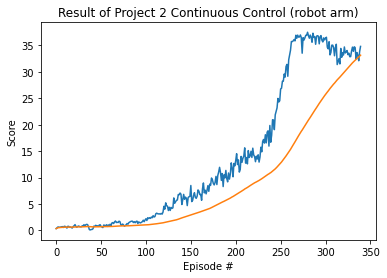

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("Result of Project 2 Continuous Control (robot arm)")
plt.plot(np.arange(len(scores)), scores, label = "ddpg agent")
plt.plot(np.arange(len(scores)), score_changes_to_plot, label = "average of scores")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [4]:
env.close()